In [1]:
# !pip install keras==2.3.1
# !pip install tensorflow==2.1.0

In [2]:
import re
import urllib
import numpy as np

from matplotlib import pyplot as plt
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K

from scipy.optimize import fmin_l_bfgs_b

tf.compat.v1.disable_eager_execution()

In [3]:
def download_image_from_URL(imageURL):
  imageName = re.search('[a-z0-9\-]+\.(jpe?g|png|gif|bmp|JPG)',imageURL, re.IGNORECASE)
  imageName = imageName.group(0)
  urllib.request.urlretrieve(imageURL, imageName)
  imagePath = "./" + imageName
  return imagePath

In [4]:
# This is the path to the image you want to transform.
target_url = "https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch12/blank-sign.jpg"
target_path = download_image_from_URL(target_url)

In [5]:
# This is the path to the style image.
style_url = "https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch12/road.jpg"
style_path = download_image_from_URL(style_url)

In [6]:
width, height = load_img(target_path).size
img_height = 400
img_width = int(width * img_height / height)

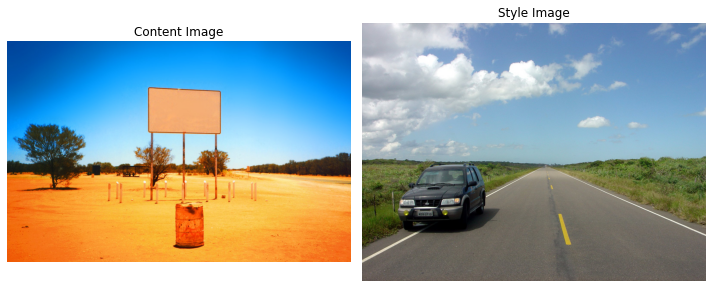

In [7]:
content = Image.open(target_path)
style = Image.open(style_path)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(content)
plt.axis("off")
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style)
plt.axis("off")
plt.title('Style Image')
plt.tight_layout()
plt.show()

**Preprocessing image for the VGG16 network**

In [8]:
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

In [9]:
def deprocess_image(x):
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

**Model Building**

In [10]:
target = K.constant(preprocess_image(target_path))
style = K.constant(preprocess_image(style_path))

In [11]:
# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

In [12]:
# We combine the 3 images into a single batch
input_tensor = K.concatenate([target, style, combination_image], axis=0)

In [13]:
# Build the VGG16 network with our batch of 3 images as input.
model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 400, 621, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 621, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 621, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 310, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 310, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 310, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 155, 128)        0     

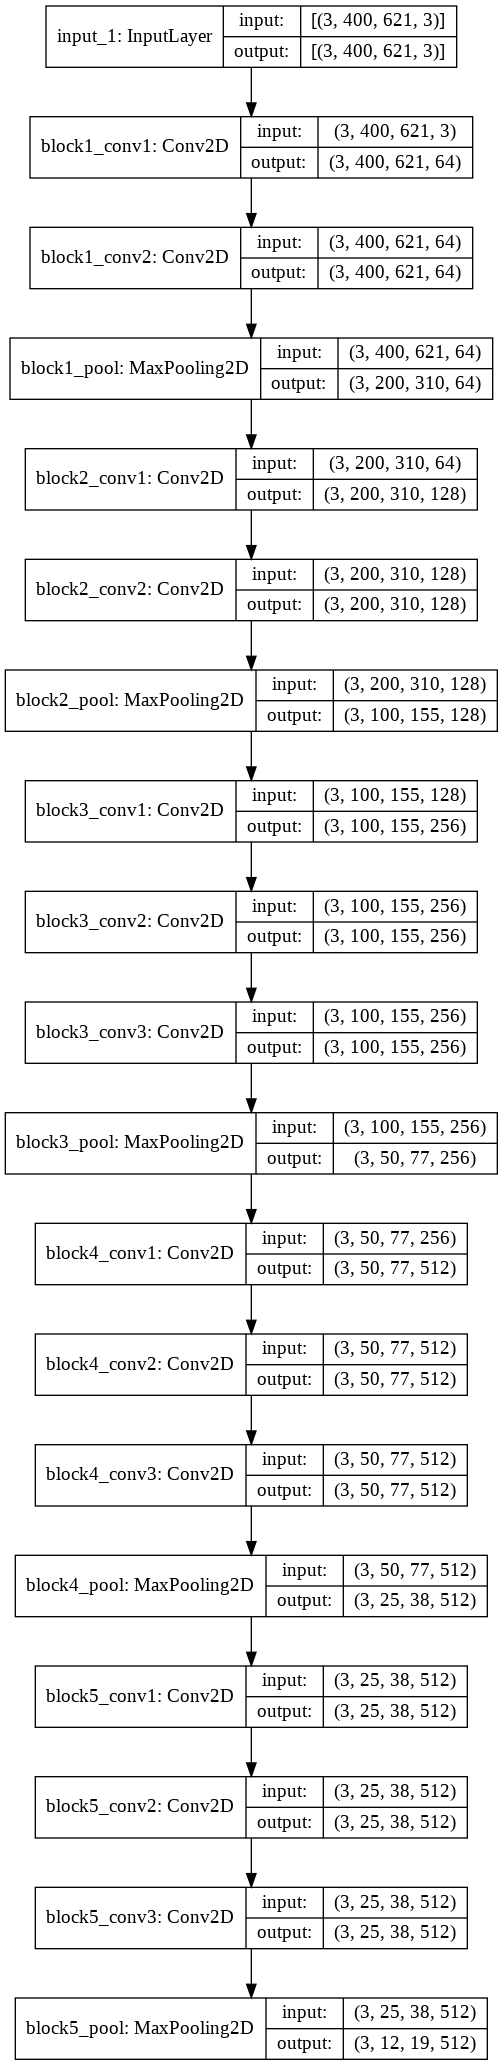

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, to_file='model.png')

**Content Loss**

In [16]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

**Style Loss**

In [17]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [18]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

**Total Variation Loss**

In [19]:
def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1,:] - x[:, 1:, :img_width - 1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1,:] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

**Computing Losses for Content and Style**

In [20]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [21]:
# Name of layer used for content loss
content_layer = 'block5_conv2'

In [22]:
# Name of layers used for style loss;
style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

In [23]:
total_variation_weight = 1e-4
style_weight = 10.
content_weight = 0.025

In [24]:
# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_features, combination_features)
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
  loss += total_variation_weight * total_variation_loss(combination_image)

**Evaluator Class**

In [25]:
grads = K.gradients(loss, combination_image)[0]
# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [26]:
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
    
evaluator = Evaluator()

**Generating Output Image**

In [ ]:
iterations = 50
x = preprocess_image(target_path)
x = x.flatten()
for i in range(1, iterations):
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun=10)
  print('Iteration %0d, loss: %0.02f' %(i, min_val))
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)

**Displaying Images**


In [ ]:
plt.figure(figsize=(50, 50))
plt.subplot(3,3,1)
plt.imshow(load_img(target_path, target_size=( img_height, img_width)))
plt.axis("off")
plt.subplot(3,3,2)
plt.imshow(load_img(style_path, target_size=( img_height,img_width)))
plt.axis("off")
plt.subplot(3,3,3)
plt.imshow(img)
plt.axis("off")
plt.show()